# `DSML Workshop 06` - Introduction to ML

In this workshop we start with hands-on machine learning focusing mostly on the linear regression example covered previously in the lecture.

Machine learning is a fast-growing field. Recent popularity of machine learning as a topic can largely be explained due to a combination of three different trends: 
1. Gains in computing power (machine learning, as it grew out of computer science, has always been fundamentally concerned with computational algorithms)
1. Massive amounts of available data (the "raw materials" for machine learning methods)
1. Some notable algorithmic advances that have occurred over the past 30 years 

To start, though, we will cover some of the most basic algorithms to codify the underlying principles. We will go through the following:
- **Task**: Getting started with ML in Python
- **Dataset**: Introducing & preparing Pittsburgh load data
- **Predicting peak demand manually**
- **Libraries for ML in Python**
- **Regression model evaluation**

---

## 1. Task: Getting started with ML in Python

This week, we will start looking at how to do machine learning in Python. Specifically, we will start predicting continuous variables.

Let's get a first understanding using a familiar dataset - the tips dataset from Seaborn. Execute the following cell to load the dataset.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


When we visualized this dataset in an earlier workshop, we noticed that there is a relationship between `total_bill` and `tip` (which is no surprise). Create a scatter plot of these two features with `total_bill` on the x-axis and `tip` on the y-axis.

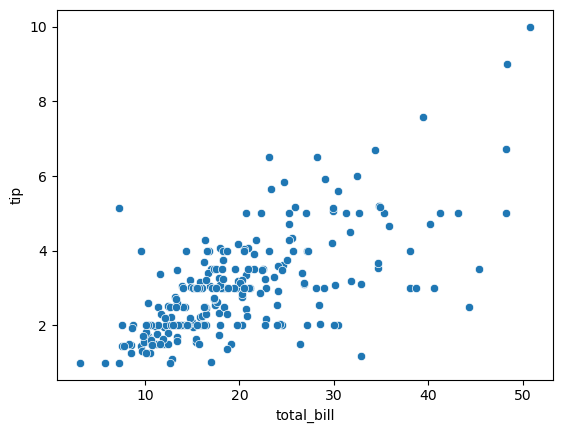

In [2]:
fig, ax = plt.subplots()
sns.scatterplot(data=tips, x="total_bill", y="tip")
plt.show()

Imagine a restaurant asks you to predict tips based on the total bill of customers. You propose to make predictions based on a simple linear model of the form
\begin{equation}
\mathrm{tip} \approx \theta_1 \cdot \mathrm{total\_bill} + \theta_2
\end{equation}
where $\theta_1$ is the slope of the line and $\theta_2$ is the intercept term.

Based on the plot you generated above, guess appropriate values for the slope and intercept and assign them to variables.

In [ ]:
slope = 0.2
intercept = -0.5

Once you have chosen values for slope and intercept, re-generate the scatter plot from above, but add your linear prediction to the plot.

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=tips, x="total_bill", y="tip")
plt.plot([0,50], [slope*0-0.5, slope*50-0.5], color="green")
plt.show()

The first observation in our tips dataset has a total bill of 17 dollars and gave a tip of 1 dollar. How far is your prediction for this observation off?

In [ ]:
# your code here
true_tip = 1
predicted_tip = slope * 17 - 0.5

print("Error:", str(abs(true_tip-predicted_tip)))

---

## 2. Dataset: Introducing & preparing Pittsburgh load data

Suppose you want to predict what the peak electricity demand will be
during the day tomorrow for some area (we'll consider data from the area
surrounding Pittsburgh, PA).  This is actually a very important problem from a
logistics planning perspective: electricity generators, which for the most part
are based upon boiling water to move turbines, cannot turn on instantly, so in
order to guarantee that we have enough power to supply a given area, a system
operator typically needs to have some excess generation always waiting in the
wings. The better we can forecast future demand, the smaller our excess margin
can be, leading to increased efficiency of the entire electrical grid.  

The power consumption tomorrow depends on many factors: temperature, day of
week, season, holiday events, etc., not to mention some inherent randomness
that we don't expect to even predict with perfect accuracy.  However, even for
someone working in the area, it would be very difficult to come up with a model 
for electricity demand based soley upon "first principles", thinking about the 
nature of electricity consumption or the devices people may use, in an attempt 
to predict future consumption.

What _is_ easy, however, is simply to collect lots of data about past energy
consumption (the system operator serving the Pittsburgh region, PJM, maintains
a data set available [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)) 
as well as the past factors that affect consumption, like the past weather for
the area. The files we are loading are the raw files we downloaded from this source. 
The final input data for our code is `Pittsburgh_load_data.csv`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime

Let's import the data, have a first look at it, and convert the 'Date' column to datetime.

In [ ]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df.head(10)

Note that 'AVG', 'MAX', and 'MIN' are in GW, 'Total' in GWh, and 'High_temp' and 'Avg_temp' in degrees Celsius.

In [ ]:
df["Date"] = pd.to_datetime(df["Date"],format="%d.%m.%Y")
df = df.sort_values("Date")
df.describe()

Today we want to build a simple ML model to forecast peak demand.
Using the converted Date column, we can have a look at the interaction between the date and the peak demand, which can be found in the 'MAX' column.

In [ ]:
fig, ax = plt.subplots(figsize = (16,9))

# Plotting the data
ax.plot(df["Date"],df[["MAX"]])
ax.set_xlabel("Date")
ax.set_ylabel("Peak Demand (GW)")
plt.show()

For now, we want to look at the summer months only. Let's create a `df_summer` which only contains the months of June, July and August.

In [ ]:
# create month feature
df["Month"] = df["Date"].apply(lambda dt: dt.month)

# create df_summer
summer_month=[6,7,8]
df_summer = df[df["Month"].isin(summer_month)==True]

df_summer.head()

In [ ]:
# let us define our dependent (y) and independent (x) variables for peak electricity load prediction
xp = df_summer['High_temp']

yp = df_summer['MAX']

In [ ]:
# let's plot our x and y
fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(xp, yp, marker='x',)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")

plt.show()

# saving figures (You can comment-out this line in order not to save figures)
#plt.savefig('summer_data_peak_demand.png')

---

## 3. Predicting peak demand manually

As it turns out, electricity consumption in the summer in Pittsburgh is largely
driven by air conditioning, so with increasing high temperature comes increasing
electricity demand.  Thus, we may hypothesize that we can form a fairly good prediction of the peak demand using a linear model: that is, we hypothesize that 
\begin{equation}
\mathrm{PeakDemand} \approx \theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
where $\theta_1$ is the slope of the line and $\theta_2$ is the intercept term (together called the _parameters_ of the model).  


For example, just eyeballing the data we might guess that the slope for peak demand data and average demand data is approximately $\theta_1 = 0.07$ (i.e., we get an increase of 0.07 GW per degree C, which we just arrived at by seeing that the power increased, very approximately, by noticing a total of ~1 GW increase in the range of 14 to 28 degree).  If we further suppose that the average peak demand is about 2.1 GW at 26 degrees C, then we can solve for the intercept term by $0.07*26 + \theta_2 = 2.1$, or $\theta_2 = 0.28$.  Note: if this seems ad-hoc to you, don't worry, it is! We will shortly decribe to actually find good values for these parameters in a disciplined way.

In [ ]:
# define theta vector with our estimated values for theta1 and theta2
theta = np.array([0.07, 0.28])

# set up plot
fig, ax = plt.subplots(figsize = (8,6))

# add objects to axis
ax.scatter(xp, yp, marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())  # gets us the limits of x and y
ax.plot(xlim,[theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
plt.show()
#plt.savefig('summer_data_peak_demand_line.pdf')

Naturally, this model won't fit the data exactly (we can see from the chart that the figure doesn't lie precisely on an exact line), but if we can find slope and intercept terms that fit the data well, then we can simply plug in tomorrow's forecasted high temperature into the equation above and get an estimate of the peak demand tomorrow (ignore the fact, for now, that the high temperature tomorrow is also a prediction - we'll assume we just get this from a reliable source, and domains like weather forecasting are extremely well-studied in practice). This is of course equivalent to just "finding a point on the line".

### Finding good parameters

The question, of course, is how to find "good" values for $\theta_1$ and $\theta_2$ that fit this data well, so that the line fits the data as "closely" as possible. The method we will describe for doing this (which is called _gradient descent_) is probably not the simplest algorithm for finding this fit. In fact, as we will see, there is a very simple closed-form expression that will immediately give us the same solution for the framework we consider here. But gradient descent is an _extremely_ powerful and general algorithm (and _is_ actually quite simple compared to some alternative approaches), and it is no exaggeration to say that gradient descent underlies virtually all modern machine learning. So, with these caveats in mind, let's dive into understanding how we find "good" parameters $\theta_1$ and $\theta_2$ in a disciplined manner.

**Objective functions**:  In order to find good values for the parameters, we need to formally define what "good" means in this setting.  This will actually be one of the key questions for machine learning algorithms in general, and different notions of "goodness" lead to different algorithms.  Fortunately, there are some very well-studied definitions in this context, and so we have some "standard" options that we can try.  The notion that we will consider here captures the idea of the "squared error" between the prediction and the actual values. That is, we consider all the days in the plot above, where $\mathrm{HighTemperature}^{(i)}$ denotes the high temperature and $\mathrm{PeakDemand}^{(i)}$ denotes the peak demand on day $i$. Since _predicted_ peak demand for day $i$ is equal to
\begin{equation}
\theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
we want to make this quantity as close as possible, averaged over all the days, to the true $\mathrm{PeakDemand}^{(i)}$.  We're going to measure this closeness in terms of the squared difference between the predicted and actual peak demand.  More formally, we would like to minimize the quantity:
\begin{equation}
\frac{1}{\# \mathrm{days}} \sum_{i \in \mathrm{days}} \left ( \theta_1 \cdot \mathrm{HighTemperature}^{(i)} + \theta_2 - \mathrm{PeakDemand}^{(i)} \right )^2 \equiv E(\theta)
\end{equation}
which we abbreviate as $E(\theta)$ to emphasize the fact that we are going to be minimizing this error by tuning our $\theta$ variables.  This is known as the _objective function_ that we are trying to minimize.  A natural question that you may be asking is: why did we choose to measure closeness using this squared difference?  Why not use the average of absolute difference?  Or the maximum absolute difference?  These are good questions, and we'll defer answering them for now, except for saying that we will definitely consider other possibilities later.  The squared error is simply a very common choice, mainly for reasons of mathematical convenience.

**Data scaling**  We'll shortly see what the gradient descent procedure looks like in our example above.  Before we apply the algorithm, though, we're going to make one small modification to our problem, and _normalize_ the data (both the inputs and the output) before we attempt to run the gradient descent algorithm.  We will see the reason for this more clearly shortly, but the brief reason is that if our slope and intercept terms are on very different "scales" (which would be the case here, because of the relatively large input values (units of degrees Celsius) compared to the output values (units of gigawatts)), then we would actually need to take very different step sizes in the two parameters $\theta_1$ and $\theta_2$.  This is possible to manually tune in our case, but when we start having many more parameters, it's not feasible.  We thus make our life much easier if we scale all the input and output data to be in the same rough range _before_ running gradient descent (Note: in class we talked about only scaling the input, which also happens to work fine here, but I think it may be easier conceptually to consider the case where we just normalize all the inputs and outputs in the same manner).

We can re-scale data in a number of ways, but a simple strategy is just to translate and scale the coordinates such that the values vary between zero and one in our dataset.  This can be easily achieved by the transformation
\begin{equation}
\tilde{x}^{(i)} = \frac{x^{(i)} - \min(x)}{\max(x) - \min(x)}
\end{equation}
and similarly for $\tilde{y}^{(i)}$. 

In [ ]:
x_nor = (xp-min(xp))/(max(xp)-min(xp))

y_nor = (yp-min(yp))/(max(yp)-min(yp))

In [ ]:
# inspect the difference after re-scaling
fig, axes = plt.subplots(1,2,figsize = (16,9))

axes[0].scatter(xp, yp, marker='x')
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Demand")

axes[1].scatter(x_nor, y_nor, marker = 'x')
axes[1].set_xlabel("Re-scaled Temperature")
axes[1].set_ylabel("Re-scaled Demand")

plt.show()

The left plot looks identical to the right plot, of course, except that the units no longer correspond to traditional quantities like degrees Celsius or gigawatts, but just some linear transformation of these units.

### Visualizing gradient descent

Now let's look at the gradient descent algorithm, which we have derived mathematically in previous lectures.  This will initialize $\theta_1$ and $\theta_2$ to zero and repeatedly update them according to the partial derivative rules.  We will use the step size (also known as learning rate) $\alpha=0.5$, and print out the value of $\theta$ per each iteration.

\begin{equation}
\theta_j  := \theta_j  − \alpha \sum_{j=1}^m (\sum_{i=1}^n \theta_j x_j^{(i)} - y^{(i)})x_j^{(i)}
\end{equation}

Note: The above simplified equation omits the number of days (n) and the *2 term which results from partial differentiation and groups them into the alpha term for easier representation.

In [ ]:
theta = np.array([0., 0.])

alpha = 0.5

for t in range(20):
    print("Iteration {}: ".format(t), theta)
    theta_old = theta.copy()
    # partial derivative theta1: 2*sum(((theta1*x + theta2)-y)*x)
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[0] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor)*x_nor)
    
    # partial derivative theta2: 2*sum(((theta1*x + theta2)-y))
    # term 2/N added here (usully included in alpha term), this is just a constant so could also be omitted
    theta[1] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor) ) # this is the intercept with a slightly different partial derivative

Let's visualize what this looks like in a couple different ways.  First, let's look at what our line looks like during different iterations of gradient descent.  For this purpose, we'll wrap the above in a simple function that takes `iters` iterations of gradient descent (note that we can of course get all these plots within a single run of gradient descent, but we'll just use multiple calls to this function for illustration purposes).

In [ ]:
def gradient_descent(iters, alpha):
    theta = np.array([0., 0.])
    for t in range(iters):
        theta_old = theta.copy()
        theta[0] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor) )
    return theta

def plot_fit(theta):
    
    Error = sum((theta[0]*x_nor + theta[1] - y_nor)**2) # simple least squares error, which underlies our OLS example
    
    # compute partial derivative (i.e. gradient) for theta 1 and 2
    def_theta1 = sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
    def_theta2 = sum((theta[0] * x_nor + theta[1] - y_nor))
    
    # plot
    
    plt.figure(figsize = (8,6))
    plt.scatter(x_nor, y_nor, marker = 'x')
    plt.xlabel("Nomalized Temperature")
    plt.ylabel("Normalized Demand")
    xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
    
    plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
    plt.xlim(xlim)
    plt.ylim(ylim)
    print('Theta = ', theta, 'Error = ',Error,'def_theta1 = ',def_theta1, 'def_theta2 = ', def_theta2 )
    #plt.savefig('gradient decent '+str(theta[0])+'.png', dpi = 300)

In [ ]:
plot_fit(gradient_descent(0, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(1, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(2, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(3, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(4, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(5, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(10, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(100, alpha=0.5))

In [ ]:
plot_fit(gradient_descent(1000, alpha=0.5))

### Error versus iteration

We can also look at the average error versus iteration.

In [ ]:
def gradient_descent_err(iters):
    err = []
    theta = np.array([0., 0.])
    alpha = 0.5
    for t in range(iters):
        theta_old = theta.copy()
        err.append(np.mean((theta_old[0] * x_nor + theta_old[1] - y_nor)**2))
        theta[0] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(xp) * 2 * sum((theta_old[0] * x_nor + theta_old[1] - y_nor) )
    return np.array(err)
plt.figure(figsize = (8,6))
plt.plot(np.arange(0,50), gradient_descent_err(50))
plt.xlabel("Iteration")
plt.ylabel("Average error")
plt.show()

### Understanding the effect of the step size (learning rate)

When using gradient descent, one of the hyperparameters we need to set is the step size (or learning rate) denoted by $\alpha$ in the gradient descent updating formula:

\begin{equation}
\theta_j  := \theta_j  − \alpha \sum_{j=1}^m (\sum_{i=1}^n \theta_j x_j^{(i)} - y^{(i)})x_j^{(i)}
\end{equation}

To understand the effect of different choices for $\alpha$, let us visualize the gradient descent iterations from our example above in a different way:

In [ ]:
# create contours of loss function using grid of theta1 and theta2 values and generating the corresponding error for all combinations
theta1_vals = np.linspace(0, 1.6, 100)
theta2_vals = np.linspace(-0.3, 0.5, 100)
se_vals = np.zeros(shape=(theta1_vals.size, theta2_vals.size)) # placeholder to be populated with errors below
for i, val_2 in enumerate(theta2_vals):
    for j, val_1 in enumerate(theta1_vals):
        se_vals[i, j] = sum((val_1*x_nor + val_2 - y_nor)**2)

# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.5)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.5)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.show()

Now, let's illustrate what happens if we set $\alpha$ to, for example, 0.6.

In [ ]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.6)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.6)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

It appears as if this was a smart move. We now arrived at a lower loss after 50 iterations compared to $\alpha = 0.5$, so let's increase our learning rate further.

In [ ]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.7)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.7)[1])

# plot
fig, ax = plt.subplots(figsize=(12,8))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

This plot looks interesting. It appears as if we are still converging, but not necessarily faster compared to $\alpha = 0.5$ or $\alpha = 0.6$. What happens if we still increase the step size?

In [ ]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.8)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.8)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

At $\alpha = 0.8$, it looks like we are diverging - we are "overshooting the target" and actually moving further away from the lowest error with each iteration. As you can see, choosing an appropriate learning rate is crucial to balance the tradeoff between converging very slowly and not converging at all.

### Getting the answer back to the original coordinates

Fortunately, we don't need to resort to solving the system in the original coordinates, we can simply solve on our normalized data and then find the corresponding equations for the original data.  Specifically, since our model gives the approximation
\begin{equation}
\begin{split}
\tilde{y} & \approx \tilde{x} \cdot \theta_1 + \theta_2\\
\Longrightarrow \;\; \frac{y-a}{b} & \approx \frac{x-c}{d} \cdot \theta_1 + \theta_2 \\
\Longrightarrow \;\; y-a & \approx ((x-c)\cdot \theta_1)/d)\cdot b + b \theta_2 \\
\Longrightarrow \;\; y & \approx x \cdot (b \theta_1/d) + b \theta_2 + a - c b \theta_1/d\\
\Longrightarrow \;\; y & \approx x \cdot \hat{\theta}_1 + \hat{\theta}_2\\
\end{split}
\end{equation}
where
\begin{equation}
a = \min_i y^{(i)}, \;\; b = \max_i y^{(i)} - \min_i y^{(i)}, \;\; c = \min_i x^{(i)}, \;\; d = \max_i x^{(i)} - \min_i x^{(i)}, 
\end{equation}
and where we define
\begin{equation}
\begin{split}
\hat{\theta}_1 & = b \theta_1/d \\
\hat{\theta}_2 & = b \theta_2 + a - c \cdot(b \theta_1/d).
\end{split}
\end{equation}
That might seem like a lot, but all it's saying is that there is an easy formula to convert between the solution we get for the normalized data and the unnormalized data.


In [ ]:
# get theta 1 and theta 2 from gradient descent
theta = gradient_descent(1000, alpha=0.5)

In [ ]:
# return thetas on normalized scale
theta

Using the above expression, let's re-scale the theta parameters to the original scale by creating a new array entitled `theta_hat`.

In [ ]:
# define a, b, c, d
a = min(yp)
b = max(yp)-min(yp)
c = min(xp)
d = max(xp) - min(xp)

# use formula from above to re-scale
theta_1 = b*theta[0]/d
theta_2 = b*theta[1] + a - c*(b*theta[0]/d)

#combine into single array
theta_hat = np.array([theta_1,theta_2])

theta_hat

Finally we plot the derived linear regression line

In [ ]:
fig,ax = plt.subplots(figsize = (8,6))


ax.scatter(xp, yp, marker='x')

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
ax.plot(xlim, [theta_hat[0]*xlim[0]+theta_hat[1], theta_hat[0]*xlim[1]+theta_hat[1]], 'C1')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
print(theta, theta_hat)

---

## 4. Libraries for ML in Python

Finally, we conclude with some information about the types of libraries we will use to run machine learning algorithms in Python.  Although there are a number of machine learning packages available, by far the most popular Python library for general-purpose "classical" machine learning (this is in contrast to packages focused specificially on deep learning, such as [TensorFlow](http://www.tensorflow.org) and [Keras](https://keras.io/getting_started/)) is the [scikit-learn](http://scikit-learn.org/) library.  Scikit Learn is a general purpose machine learning library with a number of common machine learning algorithms built in.

One important note, however, is that (despite some ongoing efforts to make it more scalable), scikit-learn is still best suited for small to medium-scale problems (say with ~10,000s of examples and ~1,000s of features). For these sized problems, most of the algorithms contained in the library will work reasonably fast, and the library has the advantage that one can train many different types of algorithms all with the same interface. However, if you have datasets that are much larger than this, then the algorithms start to get fairly slow compared to other more specialized libraries, and you are likely better off using an alternative library.

Another important caveat, and this is one that sadly often gets ignored, is that unlike other software libraries, you _need_ to have some (even just basic) understanding of what the algorithms do in order to use scikit-learn effectively.  This is because virtually all algorithms will have some substantial number of hyperparameters, settings to the algorithm that can drastically affect performance (and really, affect _all_ the underlying aspects of the algorithm itself, the hypothesis, loss, and optimization problem).  Sadly, a surprisingly large number of the statements people make about data science techniques seem less about the actual algorithms and more about whatever default settings scikit-learn happens to have for each algorithm.  This is why you get people saying things like "support vector machines worked better than neural networks for this problem", which is a completely meaningless statement unless you know _what sort_ of support vector machine, and _what architecture_ neural network was used.  Maybe in 10 years we will be at a place where the ML algorithms truly are "self-contained", and practitioners don't need to know anything about the underlying algorithms to get good performance (certainly, some researchers and companies are attempting to develop tools that move in this direction). But for the vast majority of tasks, we are still far away from this point, and you do absolutely need to understand the algorithms to get reasonable performance.

### Linear regression in scikit-learn

Let's look at how we specify a model, fit it to data, and make predictions in scikit-learn. These three tasks form the common usage pattern for most interactions with scikit-learn. Let's first prepare our data. Note that scikit-learn by default will fit a separate intercept term for linear regression models, so we don't include the all-ones entry in our features.

In [ ]:
df_summer

In [ ]:
X = df_summer["High_temp"].values.reshape((-1,1)) # if we pass a 1-feature array we need to re-shape it! This is not required for multi-dimensional arrays
y = df_summer["MAX"]

In [ ]:
X.shape

Now we can import and initialize our model. In general, scikit-learn has a different class for each different type of learning algorithm. In this case, we are importing the LinearRegression class. When we initialize the class, we pass various parameters to the constructor. In this case, we are specifying that we will fit an intercept term (i.e., we will not pass it as an explicit feature).

Note that `scikit-learn` also has a pre-implemented scaling functionality such as the `StandardScaler` class ([see here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)). For convenience we will not scale the data here. Gradient descent is still able to find an optimal solution. For higher dimensional inputs, however, scaling is highly recommended. We will cover this in future workshops!

In [ ]:
# initialize model
linear_model = LinearRegression(fit_intercept=True)

In [ ]:
linear_model

Note that when we create this class we haven't actually passed any data to the system.  This is the standard interface for scikit-learn classes: the constructor just initializes the hyperparameters of the model, and when we actually want to fit it to data, we call the `model.fit()` function.

In [ ]:
# train model
linear_model.fit(X, y)
print(linear_model.coef_, linear_model.intercept_)

In [ ]:
# compare to own implementation (at 1000 iteration of gradient descent)
theta_hat

Finally, when we want to make a prediction on a new data point, we call the model.predict() function, passing in the feature values for the new point we want to predict. In the following example, we would be predicting what the peak demand would be given a 25 degree peak temperature.

In [ ]:
# predict on new data
Xnew = np.array([[25]]) #predict peak load at 25 deg c

print(linear_model.predict(Xnew))

Note that we can pass multiple points to .predict() at once.

In [ ]:
Xnew = np.array([[25],[23]])
print(linear_model.predict(Xnew))

Using Scikit-Learn Library for plotting a linear regression line:

In [ ]:
# let's repeat our estimation procedure
lr = LinearRegression(fit_intercept=True) # initialize
lr.fit(xp.values.reshape(-1,1), yp) # train
model_pred = lr.predict(xp.values.reshape(-1,1)) # predict on original x values

# plot
fig,ax = plt.subplots(figsize = (8,6))

ax.scatter(xp, yp, marker="x")
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")

ax.plot(xp, model_pred, c='C2')
ax.legend(['Squared loss fit','Observed days'])
#plt.savefig('summer data_peak demand_line.pdf')
print(lr.coef_, lr.intercept_)

---

## 5. Regression model evaluation

### Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
y_true = df_summer["MAX"]
y_pred = linear_model.predict(df_summer["High_temp"].values.reshape((-1,1)))

#### (Root) Mean Squared Error ((R)MSE)
The MSE calculates the mean of the squared residuals. As the fitting of the linear regression model is (typically) carried out by minimizing the squared error (see loss function in lecture slides), the MSE corresponds directly to the model optimization. The unit of the MSE is the target unit squared, i.e. in the above example using energy consumption in GW, the unit of the MSE is $(GW)^2$. As the residuals (the difference of prediction and observed values) are squared, large deviations are penalized stronger than small deviations. Therefore, the weight of outliers increases using MSE as a metric. This is useful in applications where small prediction errors are not important but large errors have to be avoided.

As the squared unit is hard to interpret, the RMSE can be used instead of the MSE. The RMSE is just the square root of the MSE, meaning that it is monotonic with respect to the MSE - a bigger MSE leads to a bigger RMSE and vice versa.

In [ ]:
print("Mean Squared Error:",mean_squared_error(y_true, y_pred),"(GW)^2")
print("Root Mean Squared Error:",mean_squared_error(y_true, y_pred)**0.5,"GW")

The RMSE can be easily interpreted as it can be set into relation with the ca. 1.8 GW average demand mean. Generally, MSE and RMSE always have to be assessed given the model under evaluation. A MSE or RMSE with a certain value has no meaning unless the order of magnitude of the dataset is known (with an exception of the very unlikely case that the MSE is zero).

#### Mean Absolute Error (MAE)
Just as the RMSE, the MAE is easy to interpret. It is just the mean absolute value of the error term. When there are no or little major outliers, RMSE and MAE often have the same order of magnitude, with the MAE always being smaller than the RMSE. While a linear regression is typically fitted using the least squares method, the MAE can still be a valuable metric. It is applicable when large errors are not disproportionately worse than smaller errors. For example, when prediciting monetary values, an error of 100 USD might always be twice as bad as an error of 50 USD and so on. If this is the case, the MAE can actually be the more suitable error metric. Like the RSME, the MAE only makes sense when knowing the order of magnitude of the predicted values. On its own, it does not imply good or bad model fit.

In [ ]:
print("Mean Absolute Error:",mean_absolute_error(y_true, y_pred),"GW")

#### Coefficient of Determination ($R^2$)
The coefficient of determination (typically pronounced as "R squared"), is a metric of how well a model explains variance seen in the data. $R^2$ indicates the ratio of the explained and the overall variance (given some assumptions that we will not discuss here). Its value is always between 0 and 1. It can therefore be used as a means of comparison not only between regression methods, but also between completely different datasets - or even without knowing the data at all. For example, a value of 0.9 is always good, a value of 0.1 is always bad. Still, what threshold you would define as a good model fit depends on the domain of application. If you expect a high degree of randomness in your data, it is harder to explain your variance using a predictor. If you expect your data to be highly deterministic, then it should be easily explainable using suitable features and prediction methods. 

In [ ]:
print("Coefficient of determination:",r2_score(y_true, y_pred))

#### Other metrics
Scikit-learn does include other metrics that are not used as often as the ones explained above. To read up on those, just visit Scikit-learn's website. You can also define functions to calculate your own error metrics - depending on the application and with sound reasoning. E.g., it could make sense to weigh negative deviations higher than positive deviations, or the relative error instead of a form of absolute error could be decisive. 

__IMPORTANT: Note that the metrics calculated above represent the training loss! They do not say anything about predictive performance!__

### References
[Model Evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)

---